# Tutorial - Neural Network - Classification


We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

host_is_superhost  host_identity_verified neighbourhood_cleansed  \
0                  0                       0             Roslindale   
1                  0                       1             Roslindale   
2                  1                       1             Roslindale   
3                  0                       0             Roslindale   
4                  1                       1             Roslindale   

    latitude  longitude property_type        room_type  accommodates  \
0  42.282619 -71.133068         House  Entire home/apt             4   
1  42.286241 -71.134374     Apartment     Private room             2   
2  42.292438 -71.135765     Apartment     Private room             2   
3  42.281106 -71.121021         House     Private room             4   
4  42.284512 -71.136258         House     Private room             2   

   bathrooms  bedrooms  ...  guests_included price_per_extra_person  \
0        1.5       2.0  ...                1                      0   
1        1.0       1.0  ...                0                      0   
2        1.0       1.0  ...                1                     20   
3        1.0       1.0  ...                2                     25   
4        1.5       1.0  ...                1                      0   

   minimum_nights  number_of_reviews  number_days_btw_first_last_review  \
0               2                  0                                  0   
1               2                 36                                804   
2               3                 41                               2574   
3               1                  1                                  0   
4               2                 29                                380   

   review_scores_rating  cancellation_policy  price  price_gte_150  \
0                   NaN             moderate    250              1   
1                  94.0             moderate     65              0   
2                  98.0             moderate     65              0   
3                 100.0             moderate     75              0   
4                  99.0             flexible     79              0   

  price_category  
0        gte_226  
1         lte_75  
2         lte_75  
3         lte_75  
4     btw_75-150  

[5 rows x 23 columns]

# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                       0
host_identity_verified                  0
neighbourhood_cleansed                  0
latitude                                0
longitude                               0
property_type                           8
room_type                               0
accommodates                            0
bathrooms                              19
bedrooms                               19
beds                                   16
bed_type                                0
Number of amenities                     0
guests_included                         0
price_per_extra_person                  0
minimum_nights                          0
number_of_reviews                       0
number_days_btw_first_last_review       0
review_scores_rating                 1609
cancellation_policy                     0
price                                   0
price_gte_150                           0
price_category                          0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                             17
bedrooms                              11
beds                                   8
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 674
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks

train = train_set.drop(['price', 'price_gte_150'], axis=1)
test = test_set.drop(['price', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train['price_category']
test_y = test['price_category']

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

In [9]:
# Let's analyze "minimum_nights"

train_inputs['minimum_nights'].describe()

count    7190.000000
mean        3.031154
std         6.592199
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       273.000000
Name: minimum_nights, dtype: float64

In [10]:
train_inputs['minimum_nights'].value_counts()

1      2901
2      1980
3      1220
7       254
4       239
5       185
10      144
30       57
14       50
15       43
6        35
20       15
28       13
32        9
25        8
60        6
90        5
27        4
9         4
17        3
13        3
23        3
8         2
21        2
11        2
273       2
18        1
Name: minimum_nights, dtype: int64

<AxesSubplot:>

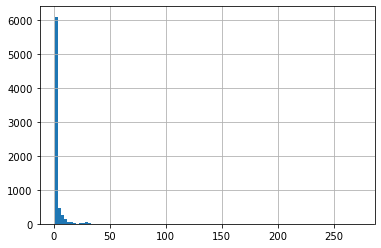

In [15]:
train_inputs['minimum_nights'].hist(bins=100)

#### Create a new categorical column: convert the minimum nights into 4 categories, equally distributed.

In [16]:
# qcut creates n quantiles (it is a discretization technique)
# Let's create 5 quantiles:
pd.qcut(train_inputs['minimum_nights'], 5, duplicates='drop')   

# Notice, it can't do 5 quantiles because of the overlapping edges. It can only 3.

3437    (0.999, 2.0]
6622    (3.0, 273.0]
2262    (0.999, 2.0]
2246      (2.0, 3.0]
835       (2.0, 3.0]
            ...     
5734      (2.0, 3.0]
5191    (0.999, 2.0]
5390    (3.0, 273.0]
860     (0.999, 2.0]
7270    (0.999, 2.0]
Name: minimum_nights, Length: 7190, dtype: category
Categories (3, interval[float64]): [(0.999, 2.0] < (2.0, 3.0] < (3.0, 273.0]]

In [17]:
pd.qcut(train_inputs['minimum_nights'],5, duplicates='drop',
        labels=['low', 'medium', 'high']).value_counts()

low       4881
medium    1220
high      1089
Name: minimum_nights, dtype: int64

In [19]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['quantile_min_nights'] = pd.qcut(train_inputs['minimum_nights'],5, duplicates='drop',
                        labels=['low', 'medium', 'high'])
    

    return df1[['quantile_min_nights']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

##  Identify the numerical and categorical columns

In [20]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [21]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [22]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [23]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [24]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [25]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [26]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [27]:
feat_eng_columns = ['minimum_nights']

# Pipeline

In [28]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [29]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [30]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [31]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [32]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [33]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-2.10940159, -1.39824237,  1.20477863, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.61906783, -1.38593382, -1.16133947, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.14448465, -0.16705969, -1.16133947, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.82039585,  0.74441303, -0.56980994, ...,  1.        ,
         0.        ,  0.        ],
       [-0.92762441,  0.3821493 , -0.56980994, ...,  0.        ,
         1.        ,  0.        ],
       [-0.34071414, -0.53929512, -1.16133947, ...,  0.        ,
         1.        ,  0.        ]])

In [34]:
train_x.shape

(7190, 64)

# Tranform: transform() for TEST

In [35]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[ 0.63069768,  0.40533687,  1.79630816, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15153485,  0.27611111, -0.56980994, ...,  0.        ,
         0.        ,  0.        ],
       [-2.02789334, -0.91924215,  0.02171958, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.15906806, -0.38872897,  1.20477863, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11838687, -0.56878308, -0.56980994, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94171792,  0.19283558, -1.16133947, ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
test_x.shape

(3082, 64)

# Baseline

In [37]:
train_y.value_counts()/len(train_y)

btw_75-150     0.332823
btw_151-225    0.241725
lte_75         0.214743
gte_226        0.210709
Name: price_category, dtype: float64

# Multiclass classification



In [38]:
from sklearn.neural_network import MLPClassifier

#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,))

mlp_clf.fit(train_x, train_y)

C:\Users\erich\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

## Accuracy

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.948817802503477

In [41]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.773523685918235

## Classification Matrix

In [42]:
from sklearn.metrics import confusion_matrix

#We usually create the confusion matrix on test set
confusion_matrix(test_y, test_y_pred)

array([[437,  75, 174,  18],
       [111, 836,  48, 104],
       [ 72,  21, 579,   3],
       [  8,  64,   0, 532]], dtype=int64)

## Increase maximum iterations for convergence

In [43]:
#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, verbose=True)

mlp_clf.fit(train_x, train_y)

Iteration 1, loss = 1.23339131
Iteration 2, loss = 0.99515419
Iteration 3, loss = 0.89690122
Iteration 4, loss = 0.84936494
Iteration 5, loss = 0.82098676
Iteration 6, loss = 0.79945932
Iteration 7, loss = 0.78277379
Iteration 8, loss = 0.76842074
Iteration 9, loss = 0.75633568
Iteration 10, loss = 0.74517936
Iteration 11, loss = 0.73627119
Iteration 12, loss = 0.72612645
Iteration 13, loss = 0.71777432
Iteration 14, loss = 0.70986074
Iteration 15, loss = 0.70108521
Iteration 16, loss = 0.69422622
Iteration 17, loss = 0.68804445
Iteration 18, loss = 0.67815615
Iteration 19, loss = 0.67058389
Iteration 20, loss = 0.66315490
Iteration 21, loss = 0.65702492
Iteration 22, loss = 0.64966308
Iteration 23, loss = 0.64298975
Iteration 24, loss = 0.63635492
Iteration 25, loss = 0.62807489
Iteration 26, loss = 0.62166893
Iteration 27, loss = 0.61543551
Iteration 28, loss = 0.60970299
Iteration 29, loss = 0.60197841
Iteration 30, loss = 0.59545301
Iteration 31, loss = 0.59080918
Iteration 32, los

Iteration 253, loss = 0.15247875
Iteration 254, loss = 0.15146109
Iteration 255, loss = 0.15218213
Iteration 256, loss = 0.15123744
Iteration 257, loss = 0.15013282
Iteration 258, loss = 0.14941717
Iteration 259, loss = 0.14855212
Iteration 260, loss = 0.14698033
Iteration 261, loss = 0.14710092
Iteration 262, loss = 0.14698538
Iteration 263, loss = 0.14568040
Iteration 264, loss = 0.14598462
Iteration 265, loss = 0.14469317
Iteration 266, loss = 0.14447965
Iteration 267, loss = 0.14310891
Iteration 268, loss = 0.14273884
Iteration 269, loss = 0.14184867
Iteration 270, loss = 0.14087959
Iteration 271, loss = 0.14137226
Iteration 272, loss = 0.13988003
Iteration 273, loss = 0.14028088
Iteration 274, loss = 0.13997962
Iteration 275, loss = 0.13778159
Iteration 276, loss = 0.13770163
Iteration 277, loss = 0.13728425
Iteration 278, loss = 0.13702538
Iteration 279, loss = 0.13586445
Iteration 280, loss = 0.13503811
Iteration 281, loss = 0.13420210
Iteration 282, loss = 0.13381851
Iteration 

Iteration 506, loss = 0.05873660
Iteration 507, loss = 0.05635059
Iteration 508, loss = 0.05820322
Iteration 509, loss = 0.05582131
Iteration 510, loss = 0.05576694
Iteration 511, loss = 0.05471651
Iteration 512, loss = 0.05494052
Iteration 513, loss = 0.05493207
Iteration 514, loss = 0.05684593
Iteration 515, loss = 0.05585284
Iteration 516, loss = 0.05471078
Iteration 517, loss = 0.05484153
Iteration 518, loss = 0.05735221
Iteration 519, loss = 0.05406821
Iteration 520, loss = 0.05469494
Iteration 521, loss = 0.05549739
Iteration 522, loss = 0.05295252
Iteration 523, loss = 0.05508189
Iteration 524, loss = 0.05490073
Iteration 525, loss = 0.05323956
Iteration 526, loss = 0.05305089
Iteration 527, loss = 0.05491668
Iteration 528, loss = 0.05412531
Iteration 529, loss = 0.05298907
Iteration 530, loss = 0.05422888
Iteration 531, loss = 0.05233433
Iteration 532, loss = 0.05192303
Iteration 533, loss = 0.05092770
Iteration 534, loss = 0.05265787
Iteration 535, loss = 0.05166949
Iteration 

MLPClassifier(max_iter=1000, verbose=True)

In [44]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9951321279554938

In [45]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7920181700194678

# Change the number of neurons

In [46]:
#Increase neurons from 100 to 50
mlp_clf = MLPClassifier(max_iter=1000, verbose=False,
                        hidden_layer_sizes=(50,))

mlp_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)

In [47]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9680111265646731

In [48]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7472420506164829

# Deep Neural Network

In [49]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000)

dnn_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000)

In [50]:
#Let's check the number of iterations:
dnn_clf.n_iter_

265

In [51]:
#Let's check the number of layers:
dnn_clf.n_layers_

5

In [52]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9791376912378303

In [53]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7410772225827384

# Deeper Neural Network

In [84]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(100,80,60,40,20,10),
                       max_iter=1000) # Funnel Shape 100,80,60,40,20,10 # Pipe Shape 30, 30, 30

dnn_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(100, 80, 60, 40, 20, 10), max_iter=1000)

In [85]:
#Let's check the number of iterations:
dnn_clf.n_iter_

62

In [86]:
#Let's check the number of layers:
dnn_clf.n_layers_

8

In [87]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9796940194714882

In [88]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7871512005191434

## Early stopping

In [60]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000,
                       early_stopping=True)

dnn_clf.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 25, 10),
              max_iter=1000)

In [61]:
#Let's check the number of iterations:
dnn_clf.n_iter_

152

In [62]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.960500695410292

In [63]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7138221933809215

## Activation function

In [64]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000,
                       activation = 'tanh') #"logistic"

dnn_clf.fit(train_x, train_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 25, 10), max_iter=1000)

In [65]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9958275382475661

In [66]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.7803374432186891

## Solver (Optimizer)

In [67]:
#Let's use Stochastic Gradient Descent optimizer

dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000,
                       activation = 'tanh',
                       solver='sgd')

dnn_clf.fit(train_x, train_y)

C:\Users\erich\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 25, 10), max_iter=1000,
              solver='sgd')

In [68]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9210013908205842

In [69]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.6810512654120701

## Prediction probabilities

In [70]:
#Select a random observation

random = test_x[50:51]
random

array([[ 0.44671982,  0.71670022,  0.61324911,  1.89706592,  1.08766162,
         0.4710924 ,  0.02385204, -0.40589026, -0.57249234, -0.00472628,
        -0.33824687,  1.57366607,  0.51641975,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ]])

In [71]:
# Observe the input variables of the observation
dnn_clf.predict_proba(random)

array([[1.75421203e-02, 3.87056487e-05, 9.82418299e-01, 8.75408730e-07]])

In [72]:
# Round the probability values
np.round(dnn_clf.predict_proba(random), 2)

array([[0.02, 0.  , 0.98, 0.  ]])